# Ejemplo de un Autoencoder


El objetivo de este código es crear una clase AutoEncoder que implemente:
- un constructor
- el metodo fit (incluye el metodo predict)
- el forward de la capa hidden
- el forward de la salida

Se prueba leyendo los datos de MNIST y se entrena el autoencoder con los datos de train y los comparamos con la salida del predict().

In [1]:
from __future__ import print_function, division
from builtins import range, input

import numpy as np
import pandas as pd
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

from sklearn.utils import shuffle


In [2]:
# funciones utilitarias

def relu(x):
    return x * (x > 0)

def error_rate(p, t):
    return np.mean(p != t)

def getMNIST():
    # columna 0 - labels
    # columna 1-785 - datos, valores 0 .. 255
    # tamaño total del CSV: (42000, 1, 28, 28)
    train = pd.read_csv('/home/jorge/data/MNIST/train.csv').as_matrix().astype(np.float32)
    train = shuffle(train)

    Xtrain = train[:-1000,1:] / 255
    Ytrain = train[:-1000,0].astype(np.int32)

    Xtest  = train[-1000:,1:] / 255
    Ytest  = train[-1000:,0].astype(np.int32)
    return Xtrain, Ytrain, Xtest, Ytest

def inicializa_pesos(shape):
    return np.random.randn(*shape) / np.sqrt(sum(shape))

### Definimos la clase AutoEncoder( )

In [3]:
class AutoEncoder(object):
    
    def __init__(self, M, an_id):          # constructor
        self.M = M
        self.id = an_id

    # Definimos el metodo fit () para la clase
    # le pasamos el propio objeto y los datos de training pero sin etiquetas porque es no-supervisado
    # tambien pasamos el learning_rate, mu para el momentum, el numero de epochs,
    # tamaño del batch y show_fig que es un flag para poder plotear el función de coste

    def fit(self, X, learning_rate=0.5, mu=0.99, epochs=1, batch_sz=100, show_fig=False):
        N, D = X.shape
        n_batches = N // batch_sz         # calculamos el numero de batches sabiendo el 
                                          # numero de muestras y el tamaño del barch

        W0 = inicializa_pesos((D, self.M))    # inicializamos W0
        self.W = theano.shared(W0, 'W_%s' % self.id)
        
        self.bh = theano.shared(np.zeros(self.M), 'bh_%s' % self.id)    # el bias de la hidden
        self.bo = theano.shared(np.zeros(D), 'bo_%s' % self.id)         # el bias de la salida
        
        self.params = [self.W, self.bh, self.bo]
        self.forward_params = [self.W, self.bh]

        # TODO: technically these should be reset before doing backprop
        self.dW = theano.shared(np.zeros(W0.shape), 'dW_%s' % self.id)
        self.dbh = theano.shared(np.zeros(self.M), 'dbh_%s' % self.id)
        self.dbo = theano.shared(np.zeros(D), 'dbo_%s' % self.id)
        self.dparams = [self.dW, self.dbh, self.dbo]
        self.forward_dparams = [self.dW, self.dbh]
   
        # La matriz de entrada es X_in
        X_in = T.matrix('X_%s' % self.id)
        # Hacemos la prediccion de X_in 
        X_hat = self.forward_output(X_in)
  
        # attach it to the object so it can be used later
        # must be sigmoidal because the output is also a sigmoid
        H = T.nnet.sigmoid(X_in.dot(self.W) + self.bh)
        self.hidden_op = theano.function(
            inputs=[X_in],
            outputs=H,
        )

        # Guardamos el metodo predict para utilizarlo como predictor de la clase
        self.predict = theano.function(
            inputs=[X_in],
            outputs=X_hat,
        )

        # Alternativas de funcion de coste
        # cost = ((X_in - X_hat) * (X_in - X_hat)).sum() / N
        cost = -(X_in * T.log(X_hat) + (1 - X_in) * T.log(1 - X_hat)).flatten().mean()
        cost_op = theano.function(
            inputs=[X_in],
            outputs=cost,
        )

        # Como se actualizan los pesos?
        updates = [
            (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ] + [
            (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ]
        
        train_op = theano.function(
            inputs=[X_in],
            updates=updates,
        )

        costs = []
        print("Entrenando al autoencoder: %s" % self.id)
        for i in range(epochs):
            print("epoch:", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(batch)
                the_cost = cost_op(batch) # technically we could also get the cost for Xtest here
                if j % 10 == 0:
                    print("j / n_batches:", j, "/", n_batches, "coste:", the_cost)
                costs.append(the_cost)
        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward_hidden(self, X):
        Z = T.nnet.sigmoid(X.dot(self.W) + self.bh)
        # Z = T.tanh(X.dot(self.W) + self.bh)
        # Z = relu(X.dot(self.W) + self.bh)
        return Z

    def forward_output(self, X):
        Z = self.forward_hidden(X)
        Y = T.nnet.sigmoid(Z.dot(self.W.T) + self.bo)
        return Y

    @staticmethod
    def createFromArrays(W, bh, bo, an_id):
        ae = AutoEncoder(W.shape[1], an_id)
        ae.W = theano.shared(W, 'W_%s' % ae.id)
        ae.bh = theano.shared(bh, 'bh_%s' % ae.id)
        ae.bo = theano.shared(bo, 'bo_%s' % ae.id)
        ae.params = [ae.W, ae.bh, ae.bo]
        ae.forward_params = [ae.W, ae.bh]
        return ae

### Probamos la clase AutoEncoder( )

In [4]:
print('Leyendo datos....')
Xtrain, Ytrain, Xtest, Ytest = getMNIST()

Leyendo datos....


In [5]:
print ("Instanciando el autoencoder....")
autoencoder = AutoEncoder(300, 0)

Instanciando el autoencoder....


Entrenando el autoencoder....


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


Entrenando al autoencoder: 0
epoch: 0
j / n_batches: 0 / 410 coste: 0.689711280894
j / n_batches: 10 / 410 coste: 0.402854086465
j / n_batches: 20 / 410 coste: 0.280462276979
j / n_batches: 30 / 410 coste: 0.270543775895
j / n_batches: 40 / 410 coste: 0.258848045596
j / n_batches: 50 / 410 coste: 0.260428604339
j / n_batches: 60 / 410 coste: 0.258534185157
j / n_batches: 70 / 410 coste: 0.245598204003
j / n_batches: 80 / 410 coste: 0.248084160037
j / n_batches: 90 / 410 coste: 0.226784911685
j / n_batches: 100 / 410 coste: 0.22448572536
j / n_batches: 110 / 410 coste: 0.213824876041
j / n_batches: 120 / 410 coste: 0.209023306444
j / n_batches: 130 / 410 coste: 0.21501502292
j / n_batches: 140 / 410 coste: 0.208373445431
j / n_batches: 150 / 410 coste: 0.206359910043
j / n_batches: 160 / 410 coste: 0.196012072857
j / n_batches: 170 / 410 coste: 0.196337131762
j / n_batches: 180 / 410 coste: 0.195671647224
j / n_batches: 190 / 410 coste: 0.184962536009
j / n_batches: 200 / 410 coste: 0.1

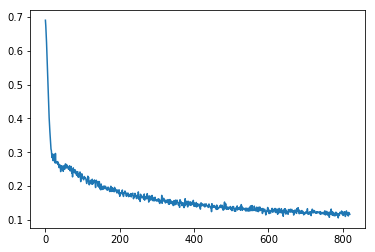

In [6]:
print ("Entrenando el autoencoder....")
autoencoder.fit(Xtrain, epochs=2, show_fig=True)

### Ahora vemos las imagenes de 5 digitos y la version 'aprendida' por el autoencoder.

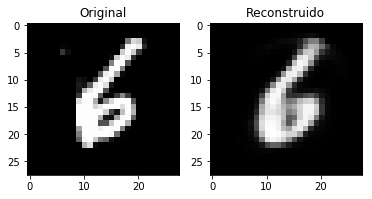

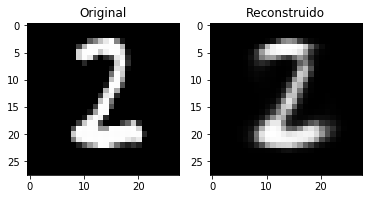

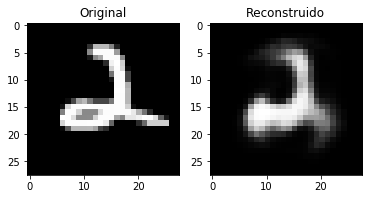

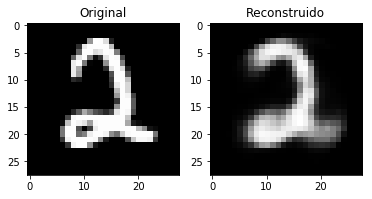

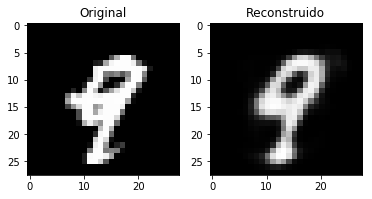

In [7]:
for p in xrange(5):
        i = np.random.choice(len(Xtest))
        x = Xtest[i]
        y = autoencoder.predict([x])
        plt.subplot(1,2,1)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.title('Original')

        plt.subplot(1,2,2)
        plt.imshow(y.reshape(28,28), cmap='gray')
        plt.title('Reconstruido')

        plt.show()
